In [2]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gensim.downloader as api
import numpy as np
from typing import List, Dict
import matplotlib.pyplot as plt
from conlleval import evaluate
import re

In [3]:
# Load pre-trained embeddings
print("Loading GloVe embeddings...")
glove_vectors = api.load('glove-wiki-gigaword-100')
print("Loading FastText embeddings...")
fasttext_vectors = api.load('fasttext-wiki-news-subwords-300')

Loading GloVe embeddings...
Loading FastText embeddings...


In [4]:
def preprocess_data(file_path: str) -> List[Dict]:
    """
    Preprocess the data with BIO encoding using exact character positions
    """
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    processed_data = []
    
    for item in data:
        original_sentence = item['sentence']
        tokens = []
        token_positions = []
        
        # Tokenize while tracking character positions
        current_word = []
        current_start = 0
        for i, c in enumerate(original_sentence + ' '):
            if c.isspace() and current_word:
                token = ''.join(current_word).lower()
                tokens.append(token)
                token_positions.append((current_start, i))
                current_word = []
                current_start = i + 1
            elif c.isalnum():
                if not current_word:
                    current_start = i
                current_word.append(c.lower())
        
        # Initialize labels with 'O'
        labels = ['O'] * len(tokens)
        
        # Create BIO labels using exact character positions
        for aspect in item['aspect_terms']:
            aspect_start = int(aspect['from'])
            aspect_end = int(aspect['to'])
            aspect_text = original_sentence[aspect_start:aspect_end].lower()
            
            # Find tokens that overlap with the aspect span
            aspect_tokens = []
            for i, (token_start, token_end) in enumerate(token_positions):
                if token_end > aspect_start and token_start < aspect_end:
                    aspect_tokens.append(i)
            
            if not aspect_tokens:
                continue
                
            # Label BIO tags
            labels[aspect_tokens[0]] = 'B'
            for j in aspect_tokens[1:]:
                labels[j] = 'I'
        
        processed_item = {
            'sentence': original_sentence,
            'tokens': tokens,
            'labels': labels,
            'aspect_terms': [aspect['term'] for aspect in item['aspect_terms']]
        }
        processed_data.append(processed_item)
    
    return processed_data

In [5]:
class AspectTermDataset(Dataset):
    def __init__(self, data, embedding_model, max_length=50):
        self.data = data
        self.embedding_model = embedding_model
        self.max_length = max_length
        self.label_map = {'O': 0, 'B': 1, 'I': 2}
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        tokens = item['tokens']
        labels = item['labels']
        
        # Convert tokens to embeddings
        embeddings = []
        for token in tokens[:self.max_length]:
            try:
                embedding = self.embedding_model[token]
            except:
                embedding = np.zeros(self.embedding_model.vector_size)
            embeddings.append(embedding)
            
        # Pad sequences
        if len(embeddings) < self.max_length:
            padding = [np.zeros(self.embedding_model.vector_size)] * (self.max_length - len(embeddings))
            embeddings.extend(padding)
        
        # Convert labels to integers with -100 for padding
        label_ids = [self.label_map[label] for label in labels[:self.max_length]]
        if len(label_ids) < self.max_length:
            label_ids.extend([-100] * (self.max_length - len(label_ids)))  # -100 is ignore index
        
        return (torch.tensor(embeddings, dtype=torch.float32),
                torch.tensor(label_ids, dtype=torch.long))


In [6]:
class RNNModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, num_classes):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

class GRUModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, num_classes):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out)
        return out

In [21]:
def convert_to_bio_labels(numeric_labels):
    """Convert numeric labels back to BIO format"""
    label_map = {0: 'O', 1: 'B', 2: 'I'}
    return [label_map[label] for label in numeric_labels if label != -100]

def plot_losses(train_losses, val_losses, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Training and Validation Losses - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Training configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = {
    'hidden_dim': 128,
    'num_layers': 2,
    'num_classes': 3,  # O, B, I
    'batch_size': 32,
    'num_epochs': 25,
    'learning_rate': 0.001
}

In [48]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, model_name, embed_name):
    train_losses = []
    val_losses = []
    best_f1 = 0
    model_path = f'{model_name}_{embed_name}.pth'
    label_map = {0: 'O', 1: 'B', 2: 'I'}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            
            # Reshape for loss calculation
            outputs = outputs.view(-1, outputs.shape[-1])
            batch_y_flat = batch_y.view(-1)
            
            loss = criterion(outputs, batch_y_flat)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        eval_lines = []
        
        with torch.no_grad():
            for batch_idx, (batch_x, batch_y) in enumerate(val_loader):
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                
                # Calculate validation loss
                outputs_flat = outputs.view(-1, outputs.shape[-1])
                batch_y_flat = batch_y.view(-1)
                loss = criterion(outputs_flat, batch_y_flat)
                total_val_loss += loss.item()
                
                # Get predictions
                predictions = torch.argmax(outputs, dim=-1)
                
                # Convert to BIO labels and format for evaluation
                batch_size = batch_y.size(0)
                for i in range(batch_size):
                    # Get original tokens from dataset
                    original_idx = batch_idx * val_loader.batch_size + i
                    if original_idx >= len(val_loader.dataset):
                        break
                    tokens = val_loader.dataset.data[original_idx]['tokens']
                    
                    # Get labels and predictions for this sample
                    sample_labels = batch_y[i].cpu().numpy()
                    sample_preds = predictions[i].cpu().numpy()
                    
                    # Iterate through each token position
                    for j in range(len(tokens)):
                        if sample_labels[j] == -100:  # Skip padding
                            continue
                        true_label = label_map.get(sample_labels[j], 'O')
                        pred_label = label_map.get(sample_preds[j], 'O')
                        eval_lines.append(f"{tokens[j]} {true_label} {pred_label}")
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Calculate metrics
        if eval_lines:
            results = evaluate(eval_lines)
            chunk_f1 = chunk_precision = chunk_recall = 0.0
            tag_f1 = tag_precision = tag_recall = 0.0
            
            # Extract metrics from the nested dictionary
            if isinstance(results, dict):
                overall_metrics = results.get('overall', {})
                
                # Chunk-level metrics
                chunks_metrics = overall_metrics.get('chunks', {})
                chunk_evals = chunks_metrics.get('evals', {})
                chunk_f1 = chunk_evals.get('f1', 0.0)
                chunk_precision = chunk_evals.get('prec', 0.0)
                chunk_recall = chunk_evals.get('rec', 0.0)
                
                # Tag-level metrics
                tags_metrics = overall_metrics.get('tags', {})
                tag_evals = tags_metrics.get('evals', {})
                tag_f1 = tag_evals.get('f1', 0.0)
                tag_precision = tag_evals.get('prec', 0.0)
                tag_recall = tag_evals.get('rec', 0.0)
            else:
                print(f"Unexpected evaluation results format: {type(results)}")
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        print(f'Chunk-level F1: {chunk_f1:.4f}, Precision: {chunk_precision:.2f}, Recall: {chunk_recall:.2f}')
        print(f'Tag-level F1: {tag_f1:.4f}, Precision: {tag_precision:.2f}, Recall: {tag_recall:.2f}')
        
        # Save best model based on chunk-level F1 score
        if epoch == num_epochs-1 and chunk_f1 > best_f1:
            best_f1 = chunk_f1
            torch.save(model.state_dict(), model_path)
            print(f"New best model saved at {model_path}")
    
    return train_losses, val_losses, model_path

In [49]:
def main():
    # Load and preprocess data
    train_data = preprocess_data('train.json')
    val_data = preprocess_data('val.json')
    
    # Save preprocessed data
    with open('train_task1.json', 'w') as f:
        json.dump(train_data, f)
    with open('val_task1.json', 'w') as f:
        json.dump(val_data, f)
    
    # Train models with different embeddings
    embedding_models = {
        'GloVe': glove_vectors,
        'FastText': fasttext_vectors
    }
    
    model_classes = {
        'RNN': RNNModel,
        'GRU': GRUModel
    }
    
    results = {}
    
    for embed_name, embed_model in embedding_models.items():
        embedding_dim = embed_model.vector_size
        
        # Create datasets
        train_dataset = AspectTermDataset(train_data, embed_model)
        val_dataset = AspectTermDataset(val_data, embed_model)
        
        train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])
        
        best_f1 = 0
        
        for model_name, model_class in model_classes.items():
            print(f"\nTraining {model_name} with {embed_name} embeddings")
            
            model = model_class(
                embedding_dim=embedding_dim,
                hidden_dim=config['hidden_dim'],
                num_layers=config['num_layers'],
                num_classes=config['num_classes']
            ).to(device)
            
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
            
            # Train the model and get the model path
            train_losses, val_losses, model_path = train_model(
                model, train_loader, val_loader, criterion, optimizer, 
                config['num_epochs'], device, model_name, embed_name
            )
            
            # Plot losses
            plot_losses(train_losses, val_losses, f"{model_name}-{embed_name}")
            
            # Save results including the model path
            results[f"{model_name}-{embed_name}"] = {
                'train_losses': train_losses,
                'val_losses': val_losses,
                'model_path': model_path  # Store the path
            }
    
    return results

In [50]:
def load_and_test(model_path, embed_name, test_file):
    # Define label map
    label_map = {0: 'O', 1: 'B', 2: 'I'}
    
    # Determine model type from path
    if 'RNN' in model_path:
        model_class = RNNModel
    else:
        model_class = GRUModel
    
    # Load embeddings
    embed_model = glove_vectors if 'glove' in embed_name.lower() else fasttext_vectors
    embedding_dim = embed_model.vector_size
    
    # Initialize model
    model = model_class(
        embedding_dim=embedding_dim,
        hidden_dim=config['hidden_dim'],
        num_layers=config['num_layers'],
        num_classes=config['num_classes']
    ).to(device)
    model.load_state_dict(torch.load(model_path))
    
    # Preprocess and load test data
    test_data = preprocess_data(test_file)
    test_dataset = AspectTermDataset(test_data, embed_model)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'])
    
    # Evaluation
    model.eval()
    eval_lines = []
    
    with torch.no_grad():
        for batch_idx, (batch_x, batch_y) in enumerate(test_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            
            # Get predictions
            predictions = torch.argmax(outputs, dim=-1)
            
            # Convert to BIO labels and format for evaluation
            batch_size = batch_y.size(0)
            for i in range(batch_size):
                # Get original tokens from dataset
                original_idx = batch_idx * test_loader.batch_size + i
                if original_idx >= len(test_loader.dataset):
                    break
                tokens = test_loader.dataset.data[original_idx]['tokens']
                
                # Get labels and predictions for this sample
                sample_labels = batch_y[i].cpu().numpy()
                sample_preds = predictions[i].cpu().numpy()
                
                # Iterate through each token position
                for j in range(len(tokens)):
                    if sample_labels[j] == -100:  # Skip padding
                        continue
                    true_label = label_map.get(sample_labels[j], 'O')
                    pred_label = label_map.get(sample_preds[j], 'O')
                    eval_lines.append(f"{tokens[j]} {true_label} {pred_label}")
    
    # Calculate metrics
    if eval_lines:
        results = evaluate(eval_lines)
        precision = recall = f1_score = accuracy = 0.0
        
        # Handle dictionary output from evaluate()
        if isinstance(results, dict):
            overall_metrics = results.get('overall', {})
            chunks_metrics = overall_metrics.get('chunks', {})
            chunk_evals = chunks_metrics.get('evals', {})
            chunk_f1 = chunk_evals.get('f1', 0.0)
            chunk_precision = chunk_evals.get('prec', 0.0)
            chunk_recall = chunk_evals.get('rec', 0.0)
            
            tags_metrics = overall_metrics.get('tags', {})
            tag_evals = tags_metrics.get('evals', {})
            tag_f1 = tag_evals.get('f1', 0.0)
            tag_precision = tag_evals.get('prec', 0.0)
            tag_recall = tag_evals.get('rec', 0.0)
        else:
            print(f"Unexpected evaluation results format: {type(results)}")
    
    print(f"\nTest Results for {model_path}:")
    print(f"Chunk-level F1: {chunk_f1:.4f}, Precision: {chunk_precision:.2f}, Recall: {chunk_recall:.2f}")
    print(f"Tag-level F1: {tag_f1:.4f}, Precision: {tag_precision:.2f}, Recall: {tag_recall:.2f}")
    
    return results


Training RNN with GloVe embeddings
Epoch [1/25]
Train Loss: 0.2997, Val Loss: 0.1691
Chunk-level F1: 0.6178, Precision: 0.61, Recall: 0.63
Tag-level F1: 0.9365, Precision: 0.94, Recall: 0.94
Epoch [2/25]
Train Loss: 0.1795, Val Loss: 0.1554
Chunk-level F1: 0.6583, Precision: 0.61, Recall: 0.71
Tag-level F1: 0.9414, Precision: 0.94, Recall: 0.94
Epoch [3/25]
Train Loss: 0.1647, Val Loss: 0.1362
Chunk-level F1: 0.6657, Precision: 0.69, Recall: 0.64
Tag-level F1: 0.9473, Precision: 0.95, Recall: 0.95
Epoch [4/25]
Train Loss: 0.1600, Val Loss: 0.1334
Chunk-level F1: 0.6572, Precision: 0.69, Recall: 0.63
Tag-level F1: 0.9470, Precision: 0.95, Recall: 0.95
Epoch [5/25]
Train Loss: 0.1507, Val Loss: 0.1363
Chunk-level F1: 0.6818, Precision: 0.67, Recall: 0.69
Tag-level F1: 0.9468, Precision: 0.95, Recall: 0.95
Epoch [6/25]
Train Loss: 0.1493, Val Loss: 0.1372
Chunk-level F1: 0.6872, Precision: 0.68, Recall: 0.69
Tag-level F1: 0.9470, Precision: 0.95, Recall: 0.95
Epoch [7/25]
Train Loss: 0.1

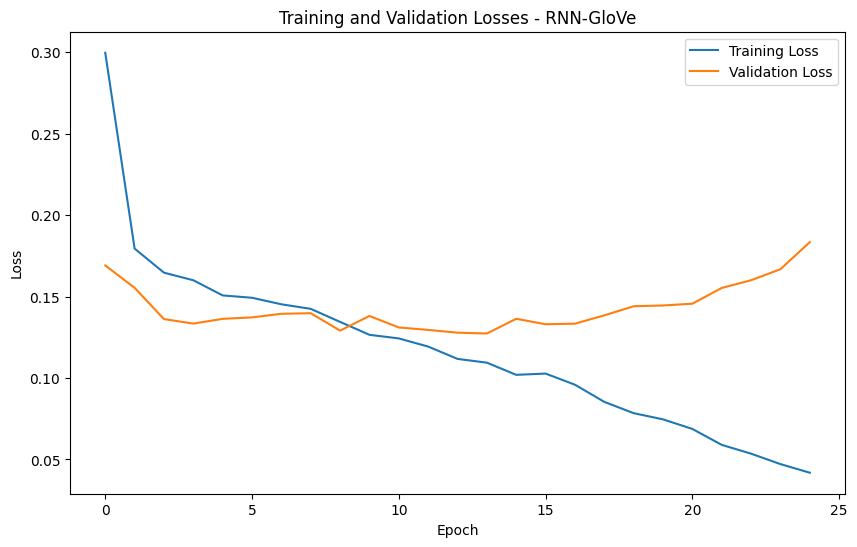


Training GRU with GloVe embeddings
Epoch [1/25]
Train Loss: 0.3400, Val Loss: 0.1681
Chunk-level F1: 0.6537, Precision: 0.68, Recall: 0.63
Tag-level F1: 0.9412, Precision: 0.94, Recall: 0.94
Epoch [2/25]
Train Loss: 0.1803, Val Loss: 0.1389
Chunk-level F1: 0.6630, Precision: 0.67, Recall: 0.66
Tag-level F1: 0.9473, Precision: 0.95, Recall: 0.95
Epoch [3/25]
Train Loss: 0.1540, Val Loss: 0.1244
Chunk-level F1: 0.6768, Precision: 0.70, Recall: 0.66
Tag-level F1: 0.9529, Precision: 0.95, Recall: 0.95
Epoch [4/25]
Train Loss: 0.1446, Val Loss: 0.1214
Chunk-level F1: 0.6953, Precision: 0.72, Recall: 0.68
Tag-level F1: 0.9534, Precision: 0.95, Recall: 0.95
Epoch [5/25]
Train Loss: 0.1375, Val Loss: 0.1190
Chunk-level F1: 0.6999, Precision: 0.72, Recall: 0.68
Tag-level F1: 0.9517, Precision: 0.95, Recall: 0.95
Epoch [6/25]
Train Loss: 0.1269, Val Loss: 0.1207
Chunk-level F1: 0.6941, Precision: 0.73, Recall: 0.66
Tag-level F1: 0.9524, Precision: 0.95, Recall: 0.95
Epoch [7/25]
Train Loss: 0.1

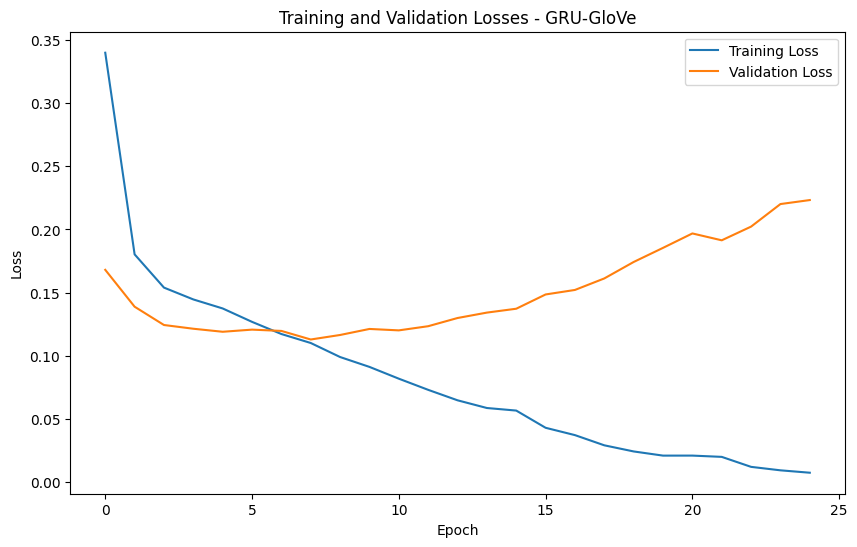


Training RNN with FastText embeddings
Epoch [1/25]
Train Loss: 0.3523, Val Loss: 0.1631
Chunk-level F1: 0.5910, Precision: 0.66, Recall: 0.53
Tag-level F1: 0.9381, Precision: 0.94, Recall: 0.94
Epoch [2/25]
Train Loss: 0.1748, Val Loss: 0.1343
Chunk-level F1: 0.6919, Precision: 0.75, Recall: 0.64
Tag-level F1: 0.9522, Precision: 0.95, Recall: 0.95
Epoch [3/25]
Train Loss: 0.1593, Val Loss: 0.1247
Chunk-level F1: 0.6974, Precision: 0.70, Recall: 0.69
Tag-level F1: 0.9517, Precision: 0.95, Recall: 0.95
Epoch [4/25]
Train Loss: 0.1431, Val Loss: 0.1253
Chunk-level F1: 0.7024, Precision: 0.70, Recall: 0.71
Tag-level F1: 0.9510, Precision: 0.95, Recall: 0.95
Epoch [5/25]
Train Loss: 0.1334, Val Loss: 0.1193
Chunk-level F1: 0.6993, Precision: 0.71, Recall: 0.69
Tag-level F1: 0.9513, Precision: 0.95, Recall: 0.95
Epoch [6/25]
Train Loss: 0.1280, Val Loss: 0.1197
Chunk-level F1: 0.7208, Precision: 0.76, Recall: 0.68
Tag-level F1: 0.9555, Precision: 0.96, Recall: 0.96
Epoch [7/25]
Train Loss: 

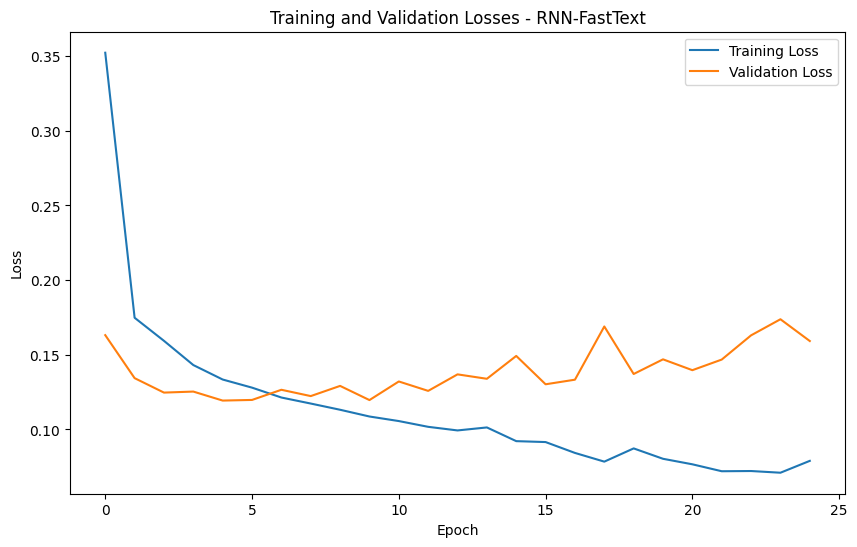


Training GRU with FastText embeddings
Epoch [1/25]
Train Loss: 0.4265, Val Loss: 0.2020
Chunk-level F1: 0.5403, Precision: 0.57, Recall: 0.51
Tag-level F1: 0.9236, Precision: 0.92, Recall: 0.92
Epoch [2/25]
Train Loss: 0.1897, Val Loss: 0.1369
Chunk-level F1: 0.6960, Precision: 0.71, Recall: 0.68
Tag-level F1: 0.9513, Precision: 0.95, Recall: 0.95
Epoch [3/25]
Train Loss: 0.1569, Val Loss: 0.1227
Chunk-level F1: 0.7022, Precision: 0.71, Recall: 0.69
Tag-level F1: 0.9517, Precision: 0.95, Recall: 0.95
Epoch [4/25]
Train Loss: 0.1449, Val Loss: 0.1262
Chunk-level F1: 0.7027, Precision: 0.67, Recall: 0.74
Tag-level F1: 0.9496, Precision: 0.95, Recall: 0.95
Epoch [5/25]
Train Loss: 0.1385, Val Loss: 0.1221
Chunk-level F1: 0.7009, Precision: 0.77, Recall: 0.64
Tag-level F1: 0.9538, Precision: 0.95, Recall: 0.95
Epoch [6/25]
Train Loss: 0.1326, Val Loss: 0.1627
Chunk-level F1: 0.6550, Precision: 0.61, Recall: 0.70
Tag-level F1: 0.9297, Precision: 0.93, Recall: 0.93
Epoch [7/25]
Train Loss: 

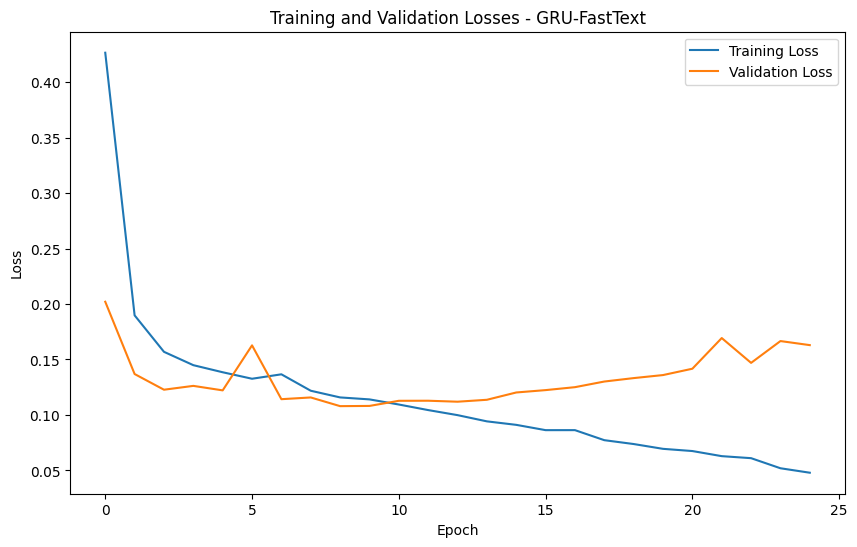

In [51]:
# After training:
train_models = main()


In [52]:
for model_key, model_info in train_models.items():
    model_path = model_info['model_path']
    embed_name = model_key.split('-')[1]  # Extract embedding name
    load_and_test(model_path, embed_name, 'val.json')


Test Results for RNN_GloVe.pth:
Chunk-level F1: 0.6573, Precision: 0.68, Recall: 0.63
Tag-level F1: 0.9452, Precision: 0.95, Recall: 0.95

Test Results for GRU_GloVe.pth:
Chunk-level F1: 0.7403, Precision: 0.71, Recall: 0.77
Tag-level F1: 0.9543, Precision: 0.95, Recall: 0.95

Test Results for RNN_FastText.pth:
Chunk-level F1: 0.6729, Precision: 0.67, Recall: 0.68
Tag-level F1: 0.9445, Precision: 0.94, Recall: 0.94

Test Results for GRU_FastText.pth:
Chunk-level F1: 0.7124, Precision: 0.70, Recall: 0.73
Tag-level F1: 0.9482, Precision: 0.95, Recall: 0.95


In [53]:
# Load and test the saved model
load_and_test('GRU_GloVe.pth', 'Glove', 'val.json')


Test Results for GRU_GloVe.pth:
Chunk-level F1: 0.7403, Precision: 0.71, Recall: 0.77
Tag-level F1: 0.9543, Precision: 0.95, Recall: 0.95


{'overall': {'chunks': {'stats': {'gold': 371, 'pred': 399, 'correct': 285},
   'evals': {'f1': 0.7402597402597404,
    'prec': 0.7142857142857143,
    'rec': 0.7681940700808625}},
  'tags': {'stats': {'gold': 4268, 'pred': 4268, 'correct': 4073},
   'evals': {'f1': 0.954311152764761,
    'prec': 0.954311152764761,
    'rec': 0.954311152764761}}},
 'slots': {'chunks': {}, 'tags': {}}}